In [2]:
# !pip install segmentation-models-pytorch==0.3.4

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
import seaborn as sns
import torch.nn as nn
from copy import copy
import torch.nn.functional as F
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import albumentations as A
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms 
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
TEST_DIR_PATH = "/kaggle/input/rois-changed-areas/0.1_changed_roi_areas_10percent/test"
TRAIN_DIR_PATH = "/kaggle/input/rois-changed-areas/0.1_changed_roi_areas_10percent/train"

### Utils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(pred_dict, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Визуализация матрицы ошибок из словаря предсказаний.
    
    Args:
        pred_dict (dict): Словарь {true_class: [predicted_classes]}
        classes (list): Список всех классов в правильном порядке
        normalize (bool): Нормализовать ли значения по строкам
        title (str): Заголовок графика
        cmap: Цветовая схема
    """
    # Инициализация матрицы
    n_classes = len(classes)
    conf_mat = np.zeros((n_classes, n_classes), dtype=np.int32)
    
    # Заполнение матрицы из словаря
    for true_class, pred_classes in pred_dict.items():
        true_idx = classes.index(true_class)
        for pred_class in pred_classes:
            pred_idx = classes.index(pred_class)
            conf_mat[true_idx][pred_idx] += 1
    
    # Нормализация (если нужно)
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [6]:
def get_folders(directory):
    folders = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            folders.append(item)
    return folders


def get_files(directory):
    files = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path):
            files.append(item)
    return files

In [7]:
def get_only_n_objects(x, n=4):
    new_x = []
    if len(x) >= n:
        step = len(x) // n
        for i in range(0, len(x), step):
            new_x.append(x[i])
            if len(new_x) == n:
                return new_x
    else:
        new_x = copy(x)
        while len(new_x) != n:
            new_x.append(
                random.choice(x)
            )
    return new_x

In [8]:
def load_images_from_dir(path_dir: str):

    class_folders_names = get_folders(path_dir)
    class_folders_pathes = [os.path.join(path_dir, folder) for folder in class_folders_names]
    nodules_seqs_dirs = []
    for class_folder_path in class_folders_pathes:
        nodules_seqs = get_folders(class_folder_path)
        nodules_seqs_dirs.extend([os.path.join(class_folder_path, seq) for seq in nodules_seqs])
        
    images_pathes = [] 
    masks_pathes = []    

    for nodule_seq_dir in tqdm(nodules_seqs_dirs):
        label = int(nodule_seq_dir.split('_')[-2][-1])
        current_images_dir = os.path.join(nodule_seq_dir, 'images')
        current_masks_dir = os.path.join(nodule_seq_dir, 'masks')

        current_images_pathes = [os.path.join(current_images_dir, x) for x in get_files(current_images_dir)]
        current_masks_pathes = [os.path.join(current_masks_dir, x) for x in get_files(current_masks_dir)]
        
        current_images_pathes.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
        current_masks_pathes.sort(key=lambda x: int(x.split('/')[-1].split('.')[0])) # Masks
        
        images_pathes.append(
            (current_images_pathes, label-2)
        )
        masks_pathes.append(
            (current_masks_pathes, label-2)
        )
        
    images_pathes_processed = []
    for curr_imgs_pathes, label in images_pathes:
        images_pathes_processed.append(
            (get_only_n_objects(curr_imgs_pathes), label)
             )
    return images_pathes_processed

In [9]:
train_images_pathes = load_images_from_dir(TRAIN_DIR_PATH)
val_images_pathes = load_images_from_dir(TEST_DIR_PATH)

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

### DataLoading DeepLab

In [11]:
def load_images_from_dir_for_deeplab(images_pathes):
    images = []
    for current_imgs_pathes, label in tqdm(images_pathes):
        current_images = []
        for image_path in current_imgs_pathes:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
                current_images.append(image)
        assert len(current_images) == 4
        images.append((current_images, label))

    return images

In [12]:
train_images_deeplab = load_images_from_dir_for_deeplab(train_images_pathes)
val_images_deeplab = load_images_from_dir_for_deeplab(val_images_pathes)

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

### Data Loading Unet

In [13]:
def load_images_from_dir_for_unet(images_pathes):
        
    images = []
    for current_imgs_pathes, label in tqdm(images_pathes):
        current_images = []
        for image_path in current_imgs_pathes:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                current_images.append(image)
        assert len(current_images) == 4
        images.append((current_images, label))

    return images

In [14]:
train_images_unet = load_images_from_dir_for_unet(train_images_pathes)
val_images_unet = load_images_from_dir_for_unet(val_images_pathes)

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

### DeepLab Dataset

In [15]:
train_images_deeplab_splitted = []
val_images_deeplab_splitted = []

for images_seq, label in train_images_deeplab:
    train_images_deeplab_splitted.extend(
        [(image, label) for image in images_seq]
    )
    
for images_seq, label in val_images_deeplab:
    val_images_deeplab_splitted.extend(
        [(image, label) for image in images_seq]
    )

In [16]:
len(train_images_deeplab_splitted), len(val_images_deeplab_splitted)

(1292, 448)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data_list, transform=None, is_imgaug=True):
        self.data_list = data_list
        self.transform = transform
        self.is_imgaug = is_imgaug
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        image, label = self.data_list[idx]
        
        if self.transform:
            if self.is_imgaug:
                transformed = self.transform(image=image)
                image = transformed["image"]
                return image[0, :, :].unsqueeze(0), torch.tensor(label, dtype=torch.long)
            else:
                transformed = self.transform(np.repeat(image[:, :, 0][:, :, np.newaxis], 3, -1))
                return transformed[0, :, :].unsqueeze(0), torch.tensor(label, dtype=torch.long)


def get_val_transforms():
    return A.Compose([
        A.Resize(height=512, width=512),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_train_transforms():
    return A.Compose([
        # Геометрические преобразования (отражения, повороты)
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Transpose(p=0.3),  # Транспонирование (поворот на 90° + отражение)
        
        # Искажения перспективы и формы
        A.Perspective(scale=(0.05, 0.1), p=0.3),  # Случайная перспектива
        A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, p=0.3),  # Эластичные деформации
        
        # Цветовые преобразования
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),  # Гамма-коррекция
        
        # Размытия и шумы
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Размытие по Гауссу
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),  # Гауссов шум
        
        # Обрезка и масштабирование
        A.Resize(height=512, width=512),  # Фиксированный размер
        
        # Нормализация и преобразование в тензор
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

train_dataset_deeplab = CustomImageDataset(
    train_images_deeplab_splitted,
    transform=get_train_transforms(),
)

test_dataset_deeplab = CustomImageDataset(
    val_images_deeplab_splitted,
    transform=get_val_transforms(),
)

train_loader = DataLoader(train_dataset_deeplab, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

In [27]:
for x, y in train_loader_deeplab:
    break

In [28]:
x.shape

torch.Size([32, 1, 512, 512])

### Unet Dataset

In [22]:
train_images_unet_splitted = []
val_images_unet_splitted = []

for images_seq, label in train_images_unet:
    train_images_unet_splitted.extend(
        [(image, label) for image in images_seq]
    )
    
for images_seq, label in val_images_unet:
    val_images_unet_splitted.extend(
        [(image, label) for image in images_seq]
    )

In [23]:
len(train_images_unet_splitted), len(val_images_unet_splitted)

(1292, 448)

In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, data_list, transform=None, is_imgaug=True):
        self.data_list = data_list
        self.transform = transform
        self.is_imgaug = is_imgaug
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        image, label = self.data_list[idx]
        
        if self.transform:
            if self.is_imgaug:
                transformed = self.transform(image=image)
                image = transformed["image"]
                return image, torch.tensor(label, dtype=torch.long)
            else:
                transformed = self.transform(np.repeat(image[:, :, 0][:, :, np.newaxis], 3, -1))
                return transformed[0, :, :].unsqueeze(0), torch.tensor(label, dtype=torch.long)


def get_val_transforms():
    return A.Compose([
        A.Resize(height=256, width=256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_train_transforms():
    return A.Compose([
        # Геометрические преобразования (отражения, повороты)
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Transpose(p=0.3),  # Транспонирование (поворот на 90° + отражение)
        
        # Искажения перспективы и формы
        A.Perspective(scale=(0.05, 0.1), p=0.3),  # Случайная перспектива
        A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, p=0.3),  # Эластичные деформации
        
        # Цветовые преобразования
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),  # Гамма-коррекция
        
        # Размытия и шумы
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Размытие по Гауссу
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),  # Гауссов шум
        
        # Обрезка и масштабирование
        A.Resize(height=256, width=256),  # Фиксированный размер
        
        # Нормализация и преобразование в тензор
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

train_dataset_unet = CustomImageDataset(
    train_images_unet_splitted,
    transform=get_val_transforms(),
)

test_dataset_unet = CustomImageDataset(
    val_images_unet_splitted,
    transform=get_val_transforms(),
)

train_loader_unet = DataLoader(train_dataset_unet, shuffle=True, batch_size=32)
test_loader_unet = DataLoader(test_dataset_unet, shuffle=True, batch_size=32)

In [25]:
for x, y in train_loader_unet:
    break

x.shape

torch.Size([32, 3, 256, 256])

### Model Definition

In [29]:
unet_plus_plus = torch.load("/kaggle/input/unet_effnetb7_pretrained/other/default/1/Unet-timm-efficientnet-b7_dice-0.950.pt", weights_only=False)
encoder = unet_plus_plus.encoder

class ClsHead(nn.Module):
    def __init__(
        self,
        n_classes=4,
    ):
        super().__init__()
        self._encoder = encoder
        self._cls_head = nn.Sequential(
            nn.Linear(640, 2),
            nn.Mish(),
            nn.Linear(2, 16),
            nn.Mish(),
            nn.Linear(16, n_classes)
        )
        
    def forward(self, x):
        with torch.no_grad():
            x = self._encoder(x)[-1]
        x = x.mean(dim=(-2, -1))
        x = self._cls_head(x)
        return x
    
cls_head_unet = ClsHead(n_classes=4)
cls_head_unet._cls_head.load_state_dict(torch.load('/kaggle/input/unet_cls_head_last/other/default/1/unet_head.pth'))
cls_head_unet.to("cuda")
None

In [36]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",
                          encoder_weights='imagenet',
                          in_channels=1, classes=1)

model_state_dict = torch.load("/kaggle/input/deeplabv3stage2_pretrained/other/default/1/fold1_stage2_trained_on_size_512.pkl", map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)
encoder = model.encoder


class ClsHead(nn.Module):
    def __init__(self, encoder, n_classes=4):
        super().__init__()
        self._encoder = encoder
        self._cls_head = nn.Sequential(
            nn.Linear(576, 4),
            nn.Mish(),
            nn.Linear(4, 8),
            nn.Mish(),
            nn.Linear(8, n_classes),
        )

    def forward(self, x):
        with torch.no_grad():
            out = torch.mean(self._encoder(x)[-1], dim=(-2, -1))
        return self._cls_head(out)
    
cls_head_deeplab = ClsHead(encoder, n_classes=4)
cls_head_deeplab._cls_head.load_state_dict(torch.load('/kaggle/input/deeplab_best_head-last/other/default/1/best_cls_head_deeplab (1).pth'))
cls_head_deeplab.to("cuda")
None

### Check model correctnes

In [37]:
deeplab_val_predictions = defaultdict(list)
    
for i in tqdm(range(len(test_dataset_deeplab))):
    with torch.no_grad():
        features, label = test_dataset_deeplab[i]
        out = cls_head_deeplab(features.to('cuda').unsqueeze(0))
        out = out[0].detach().cpu().numpy().tolist()
        pred_label = np.argmax(out)
        deeplab_val_predictions[label.item()].append(pred_label)

  0%|          | 0/448 [00:00<?, ?it/s]

In [32]:
unet_val_predictions = defaultdict(list)
    
for i in tqdm(range(len(test_dataset_unet))):
    with torch.no_grad():
        features, label = test_dataset_unet[i]
        out = cls_head_unet(features.to('cuda').unsqueeze(0))
        out = out[0].detach().cpu().numpy().tolist()
        pred_label = np.argmax(out)
        unet_val_predictions[label.item()].append(pred_label)

  0%|          | 0/448 [00:00<?, ?it/s]

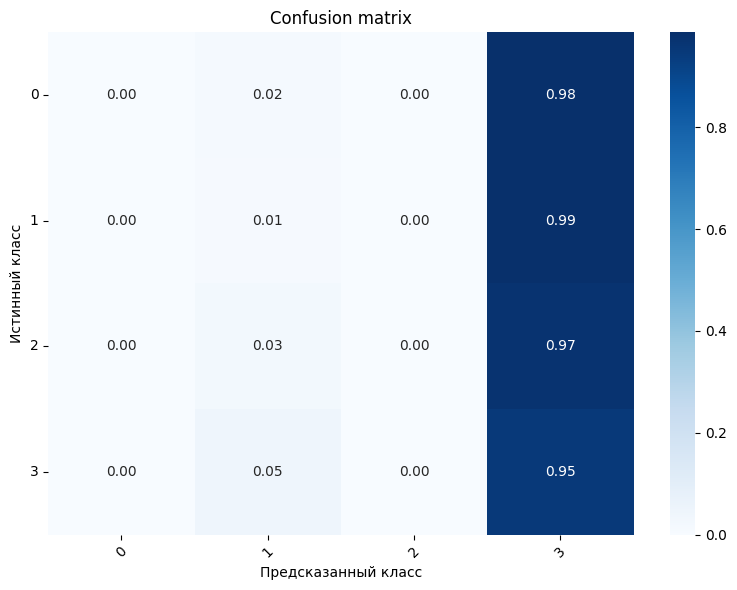

In [38]:
plot_confusion_matrix(deeplab_val_predictions, [0, 1, 2, 3])

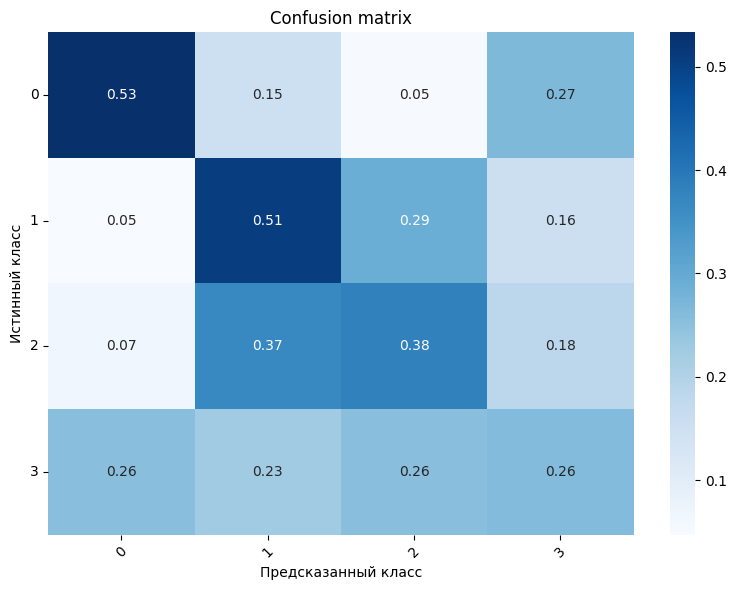

In [34]:
plot_confusion_matrix(unet_val_predictions, [0, 1, 2, 3])

### Model scoring

In [25]:
train_predictions_deeplab = []
val_predictions_deeplab = []

for i in tqdm(range(len(train_dataset_deeplab))):
    with torch.no_grad():
        features, label = train_dataset_deeplab[i]
        out = cls_head_deeplab(features.to('cuda').unsqueeze(0))
        out = out[0].detach().cpu().numpy().tolist()
        train_predictions_deeplab.append(out)
    
for i in tqdm(range(len(test_dataset_deeplab))):
    with torch.no_grad():
        features, label = test_dataset_deeplab[i]
        out = cls_head_deeplab(features.to('cuda').unsqueeze(0))
        out = out[0].detach().cpu().numpy().tolist()
        val_predictions_deeplab.append(out)

  0%|          | 0/1292 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [26]:
train_predictions_unet = []
val_predictions_unet = []

for i in tqdm(range(len(train_dataset_unet))):
    with torch.no_grad():
        features, label = train_dataset_unet[i]
        out = cls_head_unet(features.to('cuda').unsqueeze(0))
        out = out[0].detach().cpu().numpy().tolist()
        train_predictions_unet.append(out)
    
for i in tqdm(range(len(test_dataset_unet))):
    with torch.no_grad():
        features, label = test_dataset_unet[i]
        out = cls_head_unet(features.to('cuda').unsqueeze(0))
        out = out[0].detach().cpu().numpy().tolist()
        val_predictions_unet.append(out)

  0%|          | 0/1292 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [27]:
train_predictions_deeplab[0]

[-0.5444731712341309,
 0.059920575469732285,
 -0.0383809357881546,
 0.514369785785675]

In [28]:
train_predictions_unet[0]

[-0.3137292265892029,
 0.42460235953330994,
 -0.11603253334760666,
 0.35122257471084595]

In [33]:
deeplab_features_train = pd.DataFrame(train_predictions_deeplab, columns=['f1', 'f2', 'f3', 'f4'])
deeplab_features_val = pd.DataFrame(val_predictions_deeplab, columns=['f1', 'f2', 'f3', 'f4'])

unet_features_train = pd.DataFrame(train_predictions_unet, columns=['f5', 'f6', 'f7', 'f8'])
unet_features_val = pd.DataFrame(val_predictions_unet, columns=['f5', 'f6', 'f7', 'f8'])

In [34]:
train_features = pd.concat([deeplab_features_train, unet_features_train], axis=1)
val_features = pd.concat([deeplab_features_val, unet_features_val], axis=1)

In [37]:
train_labels = [train_dataset_deeplab[i][1].item() for i in range(len(train_dataset_deeplab))]
val_labels = [test_dataset_deeplab[i][1].item() for i in range(len(test_dataset_deeplab))]

In [46]:
model = CatBoostClassifier(
    iterations=1000,  # Количество деревьев
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',  # Важно для многоклассовой классификации
    eval_metric='Accuracy',      # Метрика для валидации
    random_seed=42,
    verbose=100                  # Вывод лога каждые 100 итераций
)

model.fit(
    train_features, train_labels,
    eval_set=(val_features, val_labels),
    early_stopping_rounds=50,    # Остановка, если метрика не улучшается 50 итераций
    plot=True                    # Интерактивный график обучения
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4373065	test: 0.3794643	best: 0.3794643 (0)	total: 5.11ms	remaining: 5.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3995535714
bestIteration = 44

Shrink model to first 45 iterations.


In [78]:
val_predictions = []

In [79]:
for x in val_predictions_unet:
    val_predictions.append(np.argmax(x))

In [69]:
len(train_predictions), len(train_labels)

(1292, 1292)

In [64]:
accuracy_score(train_predictions, train_labels)

0.42105263157894735

In [82]:
val_labels = [test_dataset_unet[i][1].item() for i in range(len(test_dataset_unet))]

In [83]:
accuracy_score(val_predictions, val_labels)

0.4419642857142857

In [94]:
predictions = defaultdict(list)

for i in tqdm(range(len(test_dataset_unet))):
    features, label = test_dataset_unet[i]
    out = cls_head_unet(features.to('cuda').unsqueeze(0))
    
    true_label = label.item()
    
    predictions[true_label].append(out.argmax(dim=1).item())

  0%|          | 0/448 [00:00<?, ?it/s]

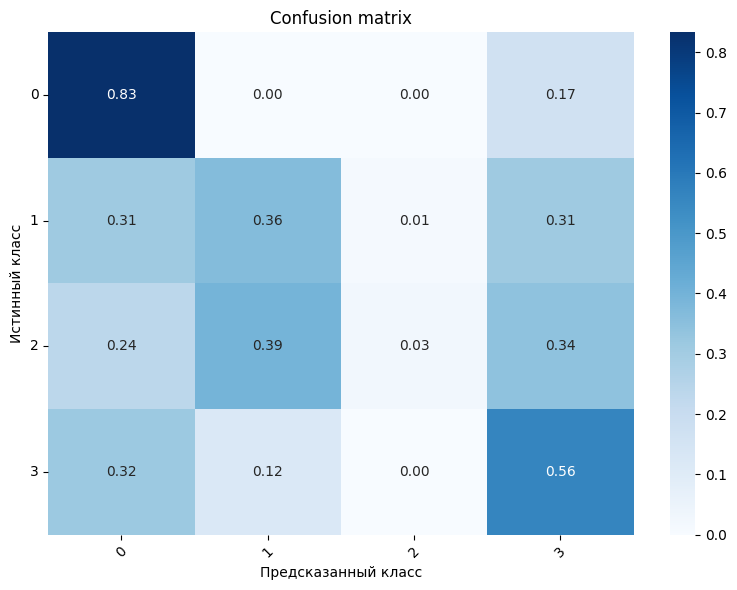

In [95]:
plot_confusion_matrix(predictions, [0, 1, 2, 3])